In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [2]:
# Utility functions


In [3]:
def show_2d(data, point):
    plt.scatter(data[:, 0], data[:, 1], c=point)
    plt.show()


In [4]:
def dunn_index(data, data_clusters):
    out_min = None
    in_max = None
    for ind_x, point_x in enumerate(data):
        for ind_y, point_y in enumerate(data[ind_x + 1:]):
            ind_y = ind_y + ind_x + 1
            dist = np.linalg.norm(point_x - point_y)
            if data_clusters[ind_x] == data_clusters[ind_y] and (in_max is None or dist > in_max):
                in_max = dist
            if data_clusters[ind_x] != data_clusters[ind_y] and (out_min is None or dist < out_min):
                out_min = dist
    return out_min / in_max


In [5]:
cancer_data = pd.read_csv("datasets/cancer.csv")
cancer_features = cancer_data.drop(['label'], axis=1).values


In [6]:
blobs_data = pd.read_csv("datasets/blobs.csv")
blobs_features = blobs_data.values


In [7]:
class Kmeans:
    def __init__(self, data, cluster_num, iter_num=50):
        self.data = data
        self.cluster_num = cluster_num
        self.iter_num = iter_num
        self.centers = self.data[np.random.choice(np.arange(self.data.shape[0]), self.cluster_num)]
        self.precalc()

    def precalc(self):
        for _ in range(self.iter_num):
            clusters_sum = np.zeros_like(self.centers)
            clusters_size = np.zeros(self.cluster_num)
            for point in self.data:
                near_center = np.argmin([np.linalg.norm(center - point) for center in self.centers])
                clusters_sum[near_center] += point
                clusters_size[near_center] += 1
            for ind in range(self.cluster_num):
                self.centers[ind] = clusters_sum[ind] / clusters_size[ind]

    def clusterize(self, data):
        cluster = np.zeros(data.shape[0])
        for index, point in enumerate(data):
            cluster[index] = np.argmin([np.linalg.norm(center - point) for center in self.centers])
        return cluster


Clusters: 2; Dunn index: 0.011020999037160844


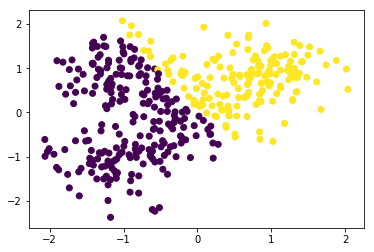

Clusters: 3; Dunn index: 0.018869269289099568


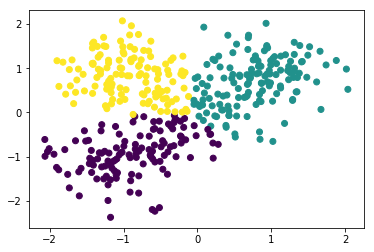

Clusters: 4; Dunn index: 0.023132837369671727


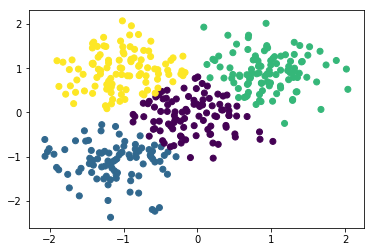

Clusters: 5; Dunn index: 0.013928274259700764


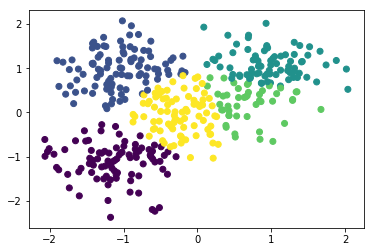

In [10]:
for cluster_num in range(2, 6):
    result = Kmeans(blobs_features, cluster_num).clusterize(blobs_features)
    dunn_ind = dunn_index(blobs_features, result)
    print(f"Clusters: {cluster_num}; Dunn index: {dunn_ind}")
    show_2d(blobs_features, result)


In [11]:
class Dbscan:
    def __init__(self, data, min_points, epsilon):
        self.data = data
        self.data_labeled = {}

        self.min_points = min_points
        self.epsilon = epsilon

        self.neighbours_eps = {}

        self.precalc()

    def precalc(self):
        point_dists = np.zeros((len(self.data), len(self.data)))
        for ind_x, point_x in enumerate(self.data):
            for ind_y, point_y in enumerate(self.data):
                point_dists[ind_x, ind_y] = np.linalg.norm(point_x - point_y)

        for point_ind, _ in enumerate(self.data):
            self.neighbours_eps[point_ind] = [cur_ind for cur_ind in range(len(self.data))
                                              if point_dists[cur_ind, point_ind] < self.epsilon]

    def clusterize(self):
        total_clusters = 0
        for point_ind, _ in enumerate(self.data):
            near_points = self.neighbours_eps[point_ind]
            if len(near_points) < self.min_points:
                self.data_labeled[point_ind] = None

            if point_ind in self.data_labeled:
                continue

            self.data_labeled[point_ind] = total_clusters
            cluster = set((point for point in near_points if point != point_ind))
            while cluster:
                point = cluster.pop()
                if point not in self.data_labeled:
                    self.data_labeled[point] = None
                    point_nearest = self.neighbours_eps[point]
                    if len(point_nearest) >= self.min_points:
                        cluster.update(point_nearest)
                if self.data_labeled[point] is None:
                    self.data_labeled[point] = total_clusters
            total_clusters += 1

        np_data_labeled = np.ones(self.data.shape[0]) * -1
        for ind, _ in enumerate(self.data):
                np_data_labeled[ind] = self.data_labeled[ind]
        return total_clusters, np_data_labeled


Clusters: 4; Dunn index: 0.0015875725449573505


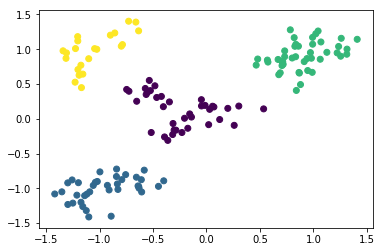

In [12]:
clusters_num, result = Dbscan(blobs_features, 15, 0.28).clusterize()
dunn_ind = dunn_index(blobs_features, result)
print(f"Clusters: {clusters_num}; Dunn index: {dunn_ind}")

show_2d(blobs_features, result)

In [13]:
class Agglomerative:
    def __init__(self, data, cluster_num):
        self.data = data
        self.cluster_num = cluster_num
        self.clusters = [{i} for i, _ in enumerate(self.data)]
        self.per_cluster_sum = [point for point in data]

        self.precalc()

    def precalc(self):
        while len(self.clusters) > self.cluster_num:
            def next():
                centers = np.array([sum_point / size for sum_point, size in
                                    zip(self.per_cluster_sum, [len(cluster) for cluster in self.clusters])])
                min_value = None
                min_index_pair = None
                for ind_x, point_x in enumerate(centers):
                    for ind_y, point_y in enumerate(centers[ind_x + 1:]):
                        ind_y = ind_y + ind_x + 1
                        if min_value is None or min_value > np.linalg.norm(point_x - point_y):
                            min_value = np.linalg.norm(point_x - point_y)
                            min_index_pair = ind_x, ind_y
                return min_index_pair

            first_cluster, second_cluster = next()
            new_cluster = self.clusters.pop(second_cluster)
            new_cluster.update(self.clusters.pop(first_cluster))
            self.clusters.append(new_cluster)
            self.per_cluster_sum.append(self.per_cluster_sum.pop(second_cluster)
                                        + self.per_cluster_sum.pop(first_cluster))

    def clusterize(self):
        result = np.zeros(len(self.data))
        for label, cluster in enumerate(self.clusters):
            for ind in cluster:
                result[ind] = label
        return result


Clusters: 2; Dunn index: 0.028830269535644968


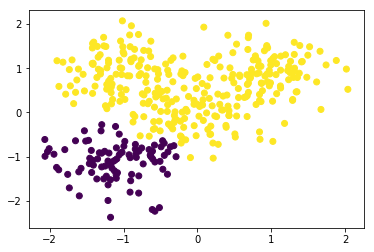

Clusters: 3; Dunn index: 0.03591922846901111


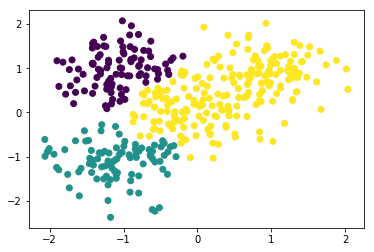

Clusters: 4; Dunn index: 0.04706477829780758


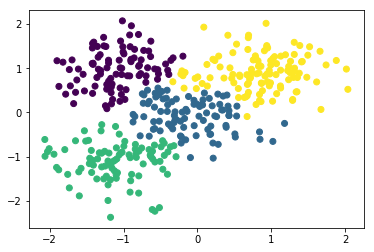

Clusters: 5; Dunn index: 0.048436252255091454


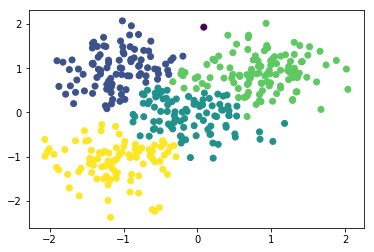

In [14]:
for cluster_num in range(2, 6):
    result = Agglomerative(blobs_features, cluster_num).clusterize()
    dunn_ind = dunn_index(blobs_features, result)

    print(f"Clusters: {cluster_num}; Dunn index: {dunn_ind}")
    show_2d(blobs_features, result)


In [22]:
def purity_index(clusterized, classes):
    cluster_to_class = {}
    total_bigges = 0
    for ind, cluster_label in enumerate(clusterized):
        class_label = classes[ind]
        if cluster_label < 0:
            continue

        if cluster_label not in cluster_to_class:
            cluster_to_class[cluster_label] = {}
        if class_label not in cluster_to_class[cluster_label]:
            cluster_to_class[cluster_label][class_label] = 1
        else:
            cluster_to_class[cluster_label][class_label] += 1

    for _, class_labels in cluster_to_class.items():
        total_bigges += max([value for _, value in class_labels.items()])
    return total_bigges / len(clusterized)


In [31]:
cancer_classes = cancer_data['label'].values


In [35]:
for cluster_num in range(2, 11):
    result = Kmeans(cancer_features, cluster_num).clusterize(cancer_features)
    purity_ind = purity_index(result, cancer_classes)
    print(f"Clusters: {cluster_num}; Purity index: {purity_ind}")


Clusters: 2; Purity index: 0.8541300527240774


Clusters: 3; Purity index: 0.8875219683655536


Clusters: 4; Purity index: 0.8347978910369068


Clusters: 5; Purity index: 0.8910369068541301


Clusters: 6; Purity index: 0.8769771528998243


Clusters: 7; Purity index: 0.8910369068541301


Clusters: 8; Purity index: 0.8875219683655536


Clusters: 9; Purity index: 0.9086115992970123


Clusters: 10; Purity index: 0.9103690685413005


In [37]:
cancer_features_norm = MinMaxScaler().fit_transform(cancer_features)
for cluster_num in range(2, 11):
    result = Kmeans(cancer_features_norm, cluster_num).clusterize(cancer_features_norm)
    purity_ind = purity_index(result, cancer_classes)
    print(f"Clusters: {cluster_num}; Purity index: {purity_ind}")


Clusters: 2; Purity index: 0.9279437609841827


Clusters: 3; Purity index: 0.9033391915641477


Clusters: 4; Purity index: 0.9103690685413005


Clusters: 5; Purity index: 0.9138840070298769


Clusters: 6; Purity index: 0.9121265377855887


Clusters: 7; Purity index: 0.8998242530755711


Clusters: 8; Purity index: 0.9068541300527241


Clusters: 9; Purity index: 0.9420035149384886


Clusters: 10; Purity index: 0.9507908611599297
